In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
#import urllib
#import os
#import copy
#from scipy.optimize import minimize
from importlib import reload

from icedef import drift, metocean, simulator, plot, iceberg, test_case
from icedef import statoil_arcticnet_data as sd

reload(drift)
reload(metocean)
reload(simulator)
reload(plot)
reload(iceberg)
reload(test_case)
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [37]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# 20180928

# Read in Beacon Data 

In [38]:
df = sd.get_df(sd.dir_path + sd.csv_filenames[1])
df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,50519,Solara,2015-04-23 18:48:37,NaN,49.22403,-51.25820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50519,Solara,2015-04-23 18:49:07,NaN,49.22401,-51.25817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50519,Solara,2015-04-23 18:49:34,NaN,49.22400,-51.25809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50519,Solara,2015-04-23 18:49:59,NaN,49.22403,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50519,Solara,2015-04-23 18:50:26,NaN,49.22399,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simulation

In [39]:
start_time, end_time

(numpy.datetime64('2015-05-06T15:27:39.000000'),
 numpy.datetime64('2015-05-07T06:25:51.000000'))

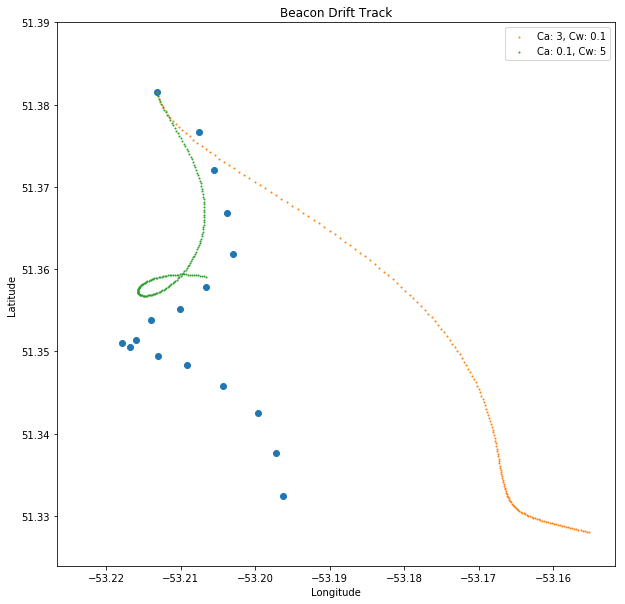

In [40]:
df = sd.get_df(sd.dir_path + sd.csv_filenames[2])
start_index = 1100
end_index = 1120
ref_berg = sd.create_ref_berg_from_df(df, start_index, end_index)
start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])
time_frame = start_time, end_time
start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_location = start_latitude, start_longitude
start_velocity = sd.get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'])

sim = simulator.Simulator()

sim.start_latitude = start_latitude
sim.start_longitude = start_longitude
sim.start_time = start_time
sim.end_time = end_time

Ca, Cw = 3, 0.1
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'start_velocity': start_velocity, 'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(store_results_as=label, **run_sim_kwargs)
plt.scatter(results['longitude'], results['latitude'], s=1, label=label)

Ca, Cw = 0.1, 5
label = f'Ca: {Ca}, Cw: {Cw}'
run_sim_kwargs = {'start_velocity': start_velocity, 'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(store_results_as=label, **run_sim_kwargs)
plt.scatter(results['longitude'], results['latitude'], s=1, label=label)

plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()


## Plot stereographically

In [41]:
my_plot = plot.Plot()

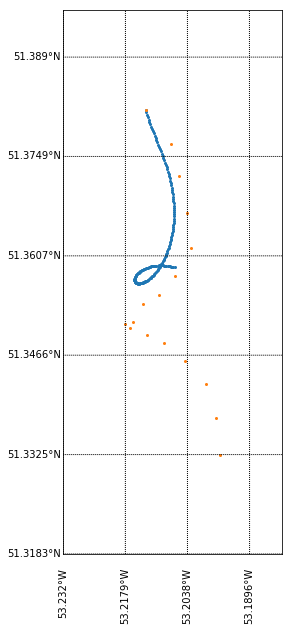

In [42]:
my_plot.plot_track(
    [results['latitude'].values, results['longitude'].values], 
    [ref_berg.history['latitude'], ref_berg.history['longitude']],
    s=4
)

# Optimization

In [12]:
tc = test_case.TestCase()

In [49]:
reload(simulator)

<module 'icedef.simulator' from '/home/evankielley/IceDEF/icedef/simulator.py'>

In [51]:
keys = ['Ca', 'Cw']
x0 = [1, 1]
bounds = [[1, 10], [1,10]]
reference_vectors = [tc.ref_lats, tc.ref_lons]

sim = simulator.Simulator()
sim.start_latitude = start_latitude
sim.start_longitude = start_longitude
sim.start_time = start_time
sim.end_time = end_time

optimization_result = sim.run_optimization(keys, x0, bounds, reference_vectors)

In [52]:
optimization_result

      fun: 0.008472958905718028
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00062478, -0.00010841])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 27
      nit: 8
   status: 0
  success: True
        x: array([ 1., 10.])

## Simulation with Optimization Result

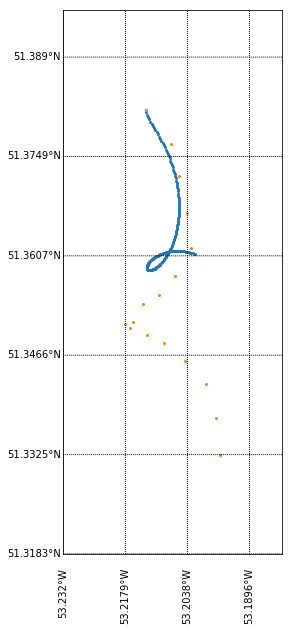

In [53]:
Ca, Cw = optimization_result.x

run_sim_kwargs = {'start_velocity': start_velocity, 'Ca': Ca, 'Cw': Cw}
results = sim.run_simulation(**run_sim_kwargs)

my_plot.plot_track(
    [results['latitude'].values, results['longitude'].values], 
    [ref_berg.history['latitude'], ref_berg.history['longitude']],
    s=4
)

# Surface Optimization

In [55]:
Ca_num = 3
Cw_num = 3
Ca_lower_bound = 1; Ca_upper_bound = 5
Cw_lower_bound = 5; Cw_upper_bound = 16

scaling = 'lin'

if scaling == 'log':

    Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
    Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

elif scaling == 'lin':
    
    Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
    Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [56]:
mse_matrix = np.zeros((Ca_num, Cw_num))
keys = ['Ca', 'Cw']
reference_vectors = [tc.ref_lats, tc.ref_lons]

for i in range(Ca_num):
    for j in range(Cw_num):
        form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
        mse_matrix[i][j] = sim.optimization_wrapper(form_drag_coefficients, keys, reference_vectors)

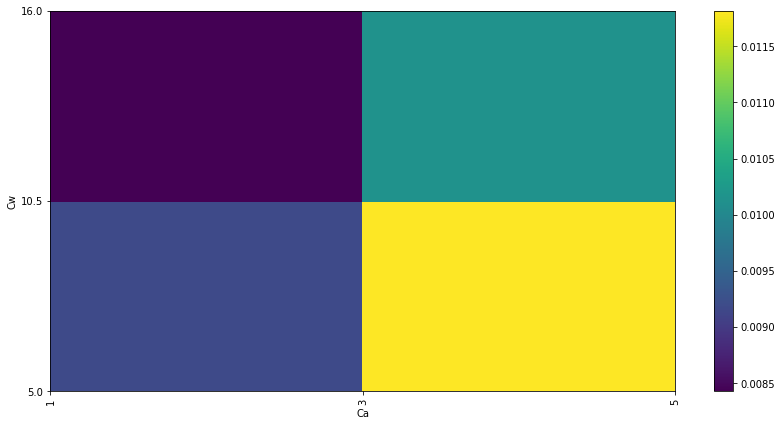

In [57]:
fig = plt.figure(figsize=(14,7))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix)#, vmin=0.02525, vmax=0.02675)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.colorbar()

plt.show()

# 20181011

In [8]:
tc = test_case.TestCase()
start_latitude = tc.start_latitude
start_longitude = tc.start_longitude
start_velocity = tc.start_velocity
start_time = tc.start_time
end_time = tc.end_time
ref_times = tc.ref_times
ref_lons = tc.ref_lons
ref_lats = tc.ref_lats

In [ ]:
xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

fig = plt.figure(figsize=(10, 5))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(ref_lons, ref_lats, s=4)

sim = simulator.Simulator()

xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=False)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='surface only')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                           start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True)

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 100m')


xds = simulator.run_simulation((start_latitude, start_longitude), (start_time, end_time), 
                                start_velocity=start_velocity, Ca=1.5, Cw=1.5, ekman=True,
                                depth_vec=np.arange(0, -1100, -100))

plt.scatter(xds['longitude'], xds['latitude'], s=4, label='ekman to 1000m')


plt.legend()
plt.show()